In [1]:
library(ggplot2)
library(Hmisc)
library(rstan)
options(mc.cores = parallel::detectCores()) # For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE) # To avoid recompilation of unchanged Stan programs, we recommend calling
#options(warn = -1)


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: StanHeaders


rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




Loading required package: StanHeaders


rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)

# Exercise 1 #

• Considering the following to sets of observations taken over a fixed large time interval in two different
corps:

| $y$ death soldiers | 0 | 1 | 2 | 3 | 4 | $\geq 5$ |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| $n_{1}$ observations | 109 | 65 | 22 | 3 | 1 | 0 |
| $n_{2}$ observations | 144 | 91 | 32 | 11 | 2 | 0 |

(a) assuming a uniform prior, compute and plot the posterior distribution for λ, the death rate over
the measurement time. Determine the posterior mean, median and variance, and compute the 95%
credibility interval.

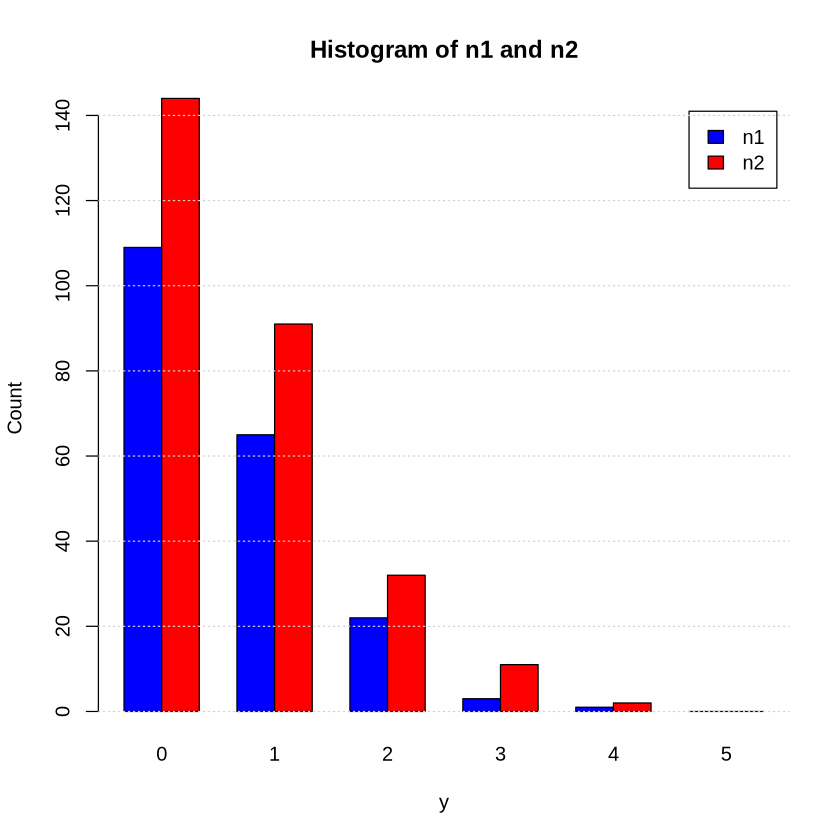

In [2]:
y <- c(0, 1, 2, 3, 4, 5)
n1 <- c(109, 65, 22, 3, 1, 0)
n2 <- c(144, 91, 32, 11, 2, 0)
n <- n1 + n2

space <- seq(0, 1.5, 0.01) # valori molto indicativi del parametro lambda, poi si mettono a posto vedendo come vengono i risultati

counts <- rbind(n1, n2)

barplot(counts, beside = TRUE, names.arg = y, col = c("blue", "red"),
        legend = c("n1", "n2"), xlab = "y", ylab = "Count", 
        main = "Histogram of n1 and n2")

grid(nx = NA, ny = NULL)

We can define the success condition as the no death condition. Therefore, the probability of observing n[0] successes is binomial process, where the probability OF THE SINGLE PROCESS is poissonian.

[1]  0 65 44  9  4  0
[1] 200


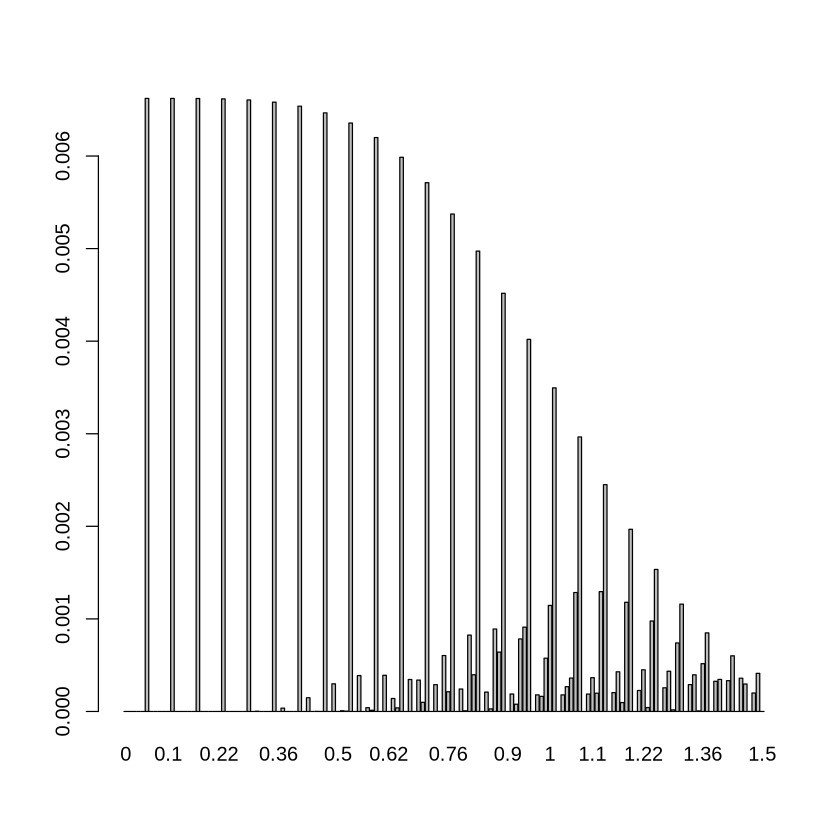

In [3]:
r <- n1 * y # number of successes
s <- sum(n1) # total observations
print(r)
print(s)

#length(space)
#length(y)
prob <- dpois(y, space)
#length(prob)
#print(prob)
likelihood <- dbinom(r, s, prob)
#print(likelihood)
prior <- replicate(length(space), 1 / length(space))

posterior <- prior * likelihood
#print(posterior)

data <- data.frame(space = space, posterior = posterior)

barplot(posterior, names.arg = space)


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


Mean 0.656912
Median 0.660000
Variance 0.001055
Credibility interval:0.6-0.72

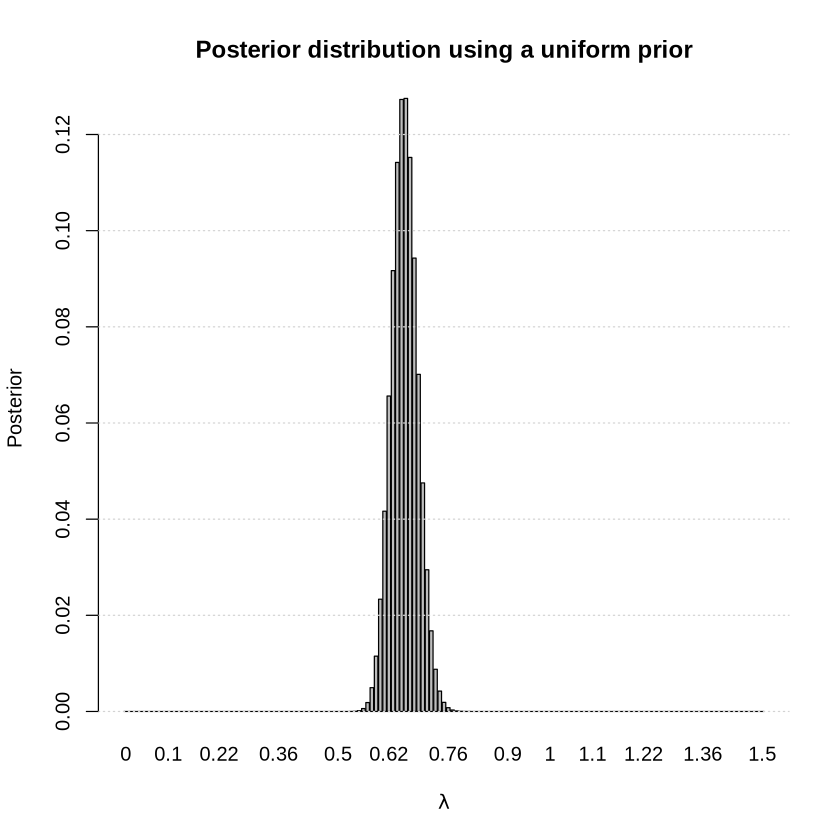

In [4]:
prior <- replicate(length(space), 1 / length(space))
prior <- prior / sum(prior)

for (i in 1:length(y)) {
    likelihood <- dbinom(n1[i], sum(n1), dpois(y[i], space))
    posterior <- prior * likelihood / sum(prior * likelihood)
    prior <- posterior
}
for (i in 1:length(y)) {
    likelihood <- dbinom(n2[i], sum(n2), dpois(y[i], space))
    posterior <- prior * likelihood / sum(prior * likelihood)
    prior <- posterior
}
barplot(posterior, names.arg = space, main = "Posterior distribution using a uniform prior",
     xlab = expression(lambda), ylab = "Posterior")

grid(nx = NA, ny = NULL)
#print(posterior)
confidence <- c(0.025, 0.975)
mean <- wtd.mean(space, posterior, normwt = TRUE)
median <- wtd.quantile(space, posterior, probs = 0.5, normwt = TRUE)
var <- wtd.var(space, posterior, normwt = TRUE)
#interval <- c(wtd.quantile(space, posterior, confidence[1], normwt = TRUE), wtd.quantile(space, posterior, confidence[1], normwt = TRUE))
interval <- wtd.quantile(space, posterior, confidence, normwt = TRUE)
cat(sprintf("Mean %3f", mean))
cat(sprintf("\nMedian %3f", median))
cat(sprintf("\nVariance %3f", var))
cat("\nCredibility interval:")
cat(interval[1])
cat("-")
cat(interval[2])

(b) assuming now a Jeffreys’ prior,
$$
g(\lambda) \propto 1 / \sqrt{\lambda}, \text { with } \lambda>0
$$

compute and plot the posterior distribution for λ, the death rate over the measurement time.
Determine the posterior mean, median and variance, and compute the 95% credibility interval

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


Mean 0.657603
Median 0.660000
Variance 0.001063
Credibility interval:0.603-0.72

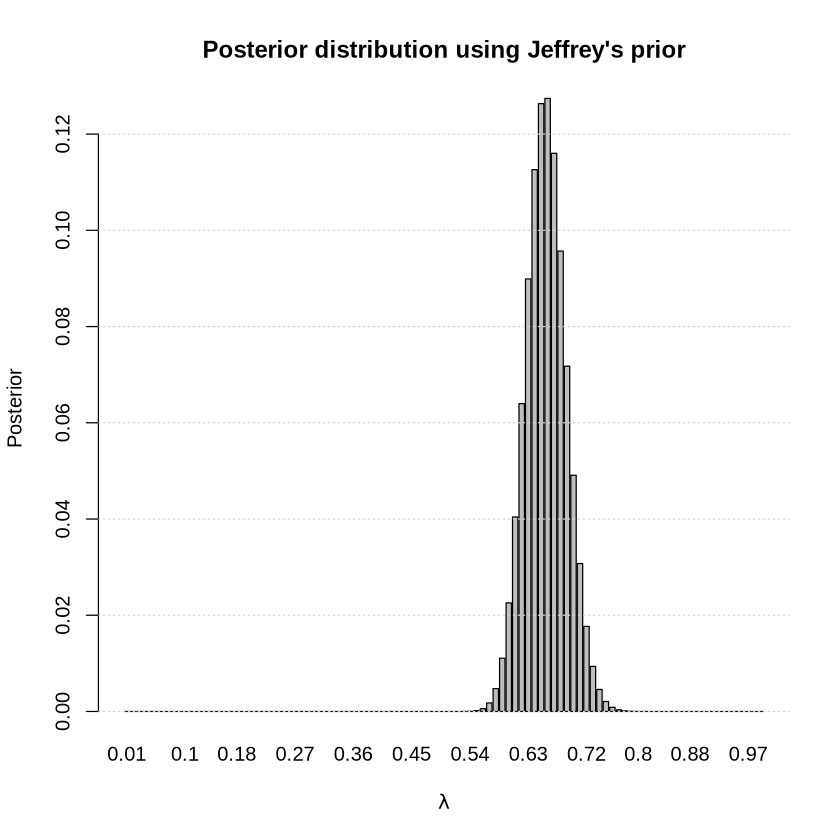

In [5]:
space <- seq(0.01, 0.99, 0.01)
prior <- dbeta(space, 0.5, 0.5)
prior <- prior / sum(prior)
#print(prior)

for (i in 1:length(y)) {
    likelihood <- dbinom(n1[i], sum(n1), dpois(y[i], space))
    posterior <- prior * likelihood / sum(prior * likelihood)
    prior <- posterior
}
for (i in 1:length(y)) {
    likelihood <- dbinom(n2[i], sum(n2), dpois(y[i], space))
    posterior <- prior * likelihood / sum(prior * likelihood)
    prior <- posterior
}
#print(posterior)
barplot(posterior, names.arg = space, main = "Posterior distribution using Jeffrey's prior",
     xlab = expression(lambda), ylab = "Posterior")

grid(nx = NA, ny = NULL)
#print(posterior)
confidence <- c(0.025, 0.975)
mean <- wtd.mean(space, posterior, normwt = TRUE)
median <- wtd.quantile(space, posterior, probs = 0.5, normwt = TRUE)
var <- wtd.var(space, posterior, normwt = TRUE)
#interval <- c(wtd.quantile(space, posterior, confidence[1], normwt = TRUE), wtd.quantile(space, posterior, confidence[1], normwt = TRUE))
interval <- wtd.quantile(space, posterior, confidence, normwt = TRUE)
cat(sprintf("Mean %3f", mean))
cat(sprintf("\nMedian %3f", median))
cat(sprintf("\nVariance %3f", var))
cat("\nCredibility interval:")
cat(interval[1])
cat("-")
cat(interval[2])

# Exercise 2 #

• solve Exercise 1 using a Markov Chain Monte Carlo using stan.

In [12]:
X <- rep(y, n) # n = n1 + n2

modelStan = '
    data {
        int<lower=0> N;
        int<lower=0> X[N];
    }
    parameters {
        real<lower=0, upper=1.5> lambda;
    }
    model {
        X ~ poisson(lambda);
        lambda ~ beta(1,1);
    }
'
mod <- stan_model(model_code = modelStan, model_name = "stan_modelR", verbose = TRUE)
fit <- sampling(mod, data = list(X = X, N = length(X)), 
    chains = 3, iter = 1000, warmup = 200, thin = 1)

stansummary = summary(object = fit)

mean <- stansummary$summary[1,1]
median <- stansummary$summary[1,6]
var <- stansummary$summary[1,3] **2
interval <- c(stansummary$summary[1,4], stansummary$summary[1,8])
cat(sprintf("Mean %3f", mean))
cat(sprintf("\nMedian %3f", median))
cat(sprintf("\nVariance %3f", var))
cat("\nCredibility interval:")
cat(interval[1])
cat("-")
cat(interval[2])


TRANSLATING MODEL 'stan_modelR' FROM Stan CODE TO C++ CODE NOW.
Mean 0.664247
Median 0.663335
Variance 0.001339
Credibility interval:0.5938175-0.7357981

# Exercise 3 #